## A Recommender System For Netflix Movies :popcorn::dvd:

### Background
In 2006, Netflix issued a challenge that was hard (for us plebeians) to ignore: any team that developed a recommender system for movies using data collected by the streaming service that could beat their in-house _Cinematch_ algorithm's error score by at least 10% would receive a $1 million prize. In spite of the competition having ended more than a decade ago, I have decided to put my skills to the test by developing a recommender system of my own using the same dataset.

### Implementation Details
I downloaded the official _Netflix Prize_ dataset published by Netflix on Kaggle (https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data). In this example, I aim to beat the company's original RMSE (root-mean-square error) of 0.9525 as per the [contest rules](https://web.archive.org/web/20100106185508/http://www.netflixprize.com//rules). Unfortunately, as the test set is not provided, I will only be able to test my model on the training set. For this model, I will use a basic function based on one that was demonstrated in my recommender systems class. _Be forewarned: there will be a lot of math ahead (feel free to skip to the code/results)._

The model in question is a function of the average rating across the database (the mean of every rating made), each user's average deviation from the mean, each movie's average deviation from the mean, and an alignment score between the user and the movie. Our rating prediction function is then

$$f(u,m) = \mu + \delta_u + \delta_m + \alpha_u \cdot \beta_m$$

where $\mu$ is the average rating, $\delta_u$ is user $u$'s average deviation from the mean, $\delta_m$ is movie $m$'s average deviation from the mean, and $\alpha_u,\beta_m \in \mathbb{R}^k$ are the respective vector representations of the user and the movie (their dot product constitutes an alignment score). We want to minimize the mean squared error (MSE) since it is equivalent to minimizing the RMSE, and we will include a regularizer in our loss function for generalization.

$$L(\alpha, \beta, \delta) = \underbrace{\sum_{u,m} \left(f(u,m) - R_{u,m}\right)^2}_{\text{MSE}} + \underbrace{\lambda\left(\sum_u \delta_u + \sum_m \delta_m + \sum_u ||\alpha_u||_2^2 + \sum_m ||\beta_m||_2^2\right)}_{\text{regularizer}}$$

where we are taking $R_{u,m}$ to be any of user $u$'s ratings of movie $m$ (permitting duplicates). Additionally, since this rating value is only defined for certain pairings, the sum will be restricted only to such user-movie pairs. The optimization method we will apply entails setting the partial derivative of the loss with respect to each parameter equal to zero, then updating each parameter according to its closed form solution.

$$\frac{\partial L}{\partial \delta_v} = 2 \cdot \sum_m \left(f(v,m) - R_{v,m}\right) + \lambda = 0 \implies$$

$$\delta_v = \frac{\sum_m \left(R_{v,m} - \mu - \delta_m - \alpha_v \cdot \beta_m\right) - \lambda/2}{M} \qquad \text{where user } v \text{ made } M \text{ ratings}$$

$$\frac{\partial L}{\partial \delta_n} = 0 \implies \delta_n = \frac{\sum_u \left(R_{u,n} - \mu - \delta_u - \alpha_v \cdot \beta_m\right) - \lambda/2}{U} \qquad \text{where movie } n \text{ was rated } U \text{ times}$$

$$\frac{\partial L}{\partial \alpha_v} = 2 \cdot \sum_m \left(f(v,m) - R_{v,m}\right) \beta_m + 2\lambda \alpha_v = \vec{0} \implies$$

$$\alpha_v = \left(\sum_m \beta_m \beta_m^T + \lambda I\right)^{-1} \sum_m \left(R_{v,m} - \mu - \delta_v - \delta_m\right) \beta_m$$

$$\frac{\partial L}{\partial \beta_n} = \vec{0} \implies \beta_n = \left(\sum_u \alpha_u \alpha_u^T + \lambda I\right)^{-1} \sum_u \left(R_{u,n} - \mu - \delta_u - \delta_n\right) \alpha_u$$

Since we assume all the $\alpha_u, \beta_m$ are linearly independent, the respective inverse matrices are defined for $U,M \geq k$ and small $\lambda$. However, for singular matrices, we must compute the Moore-Penrose pseudoinverse in its place. We will take advantage of a numpy function with an efficient algorithm for our particular case (as the matrices are always Hermitian).

### Preparing the Data
Netflix informs on the Kaggle page where the data are listed that there are 480,189 users with nonconsecutive IDs. In order to efficiently represent data, I will only use a users-per-movie representation of ratings data, but will convert the users to an index-based system for ease of use.

In [1]:
# Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from csv import reader

# Configure matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
mpl.rcParams['figure.dpi'] = 200

In [2]:
# Initialize ratings
raw_ratings = {}

# For indexing users
id_to_index = {}

def read_values(f):
    mov_no = -1 # Filler
    r = []
    user_count = len(id_to_index)
    
    # Read lines from file
    for line in f.readlines():
        if line[-2] == ':':
            if mov_no == -1: mov_no = int(line[:-2])
            else:
                if mov_no in raw_ratings.keys():
                    raw_ratings[mov_no] += r
                else:
                    raw_ratings[mov_no] = r
                    
                mov_no = int(line[:-2])
                r = []
        else:
            user, rating = line.split(',')[:2]
            user, rating = int(user), int(rating)
            
            if user in id_to_index:
                user = id_to_index[user]
            else:
                id_to_index[user] = user = user_count
                user_count += 1
                
            r += [[user, rating]]
    
    # Add last ratings to dictionary and close file
    raw_ratings[mov_no] = r
    f.close()

# Read data from files
for i in range(4):
    with open(f'Netflix Prize/combined_data_{i+1}.txt', 'r', 4000000) as f:
        read_values(f)

        
# Ensure movie ratings are in order
movies = list(raw_ratings.keys())
movies.sort()
    
# Update ratings to array structure for efficiency
ratings = []
for movie in movies:
    ratings += [np.sort(raw_ratings.pop(movie), axis=0)]

# Keep track of movie ratings by each user
ratings_by_user = [[] for _ in range(len(id_to_index))]
for m, movie in enumerate(ratings):
    for n, pair in enumerate(movie):
        ratings_by_user[pair[0]] += [[m, pair[1]]]
        
# Convert ratings_by_user to use numpy for speed
for u, user in enumerate(ratings_by_user):
    ratings_by_user[u] = np.array(user)

### Building & Training the Model

Since the user IDs are sparse, we will represent per-user parameters as dictionaries. The per-movie parameters will more naturally be expressed as lists. However, we will first compute $\mu$ (the average rating across the dataset).

In [3]:
ratings_count = 0
ratings_total = 0

for movie in ratings:
    ratings_count += len(movie)
    ratings_total += np.sum(movie, axis=0)[1]
    
mu = ratings_total / ratings_count
mu

3.604289964420661

In [4]:
# Size of alignment vectors
k = 10

# Ratings deltas
du = np.random.normal(size=len(id_to_index))
dm = np.random.normal(size=len(ratings))

# User/movie alignments
au = np.random.normal(size=(len(id_to_index), k))
bm = np.random.normal(size=(len(ratings), k))

Here, we will define functions for rating predictions and update steps.

In [5]:
# Returns the user-movie rating prediction from the model
def rate(user, movie):
    return mu + du[user] + dm[movie] + au[user] @ bm[movie].T

# Updates dm and bm by one step (l is reg. constant)
def update_movies(l=0.01):
    for m, movie in enumerate(ratings):
        # Users who rated movie & count thereof
        users = movie[:,0]
        num_users = len(users)

        # Alignment vectors
        alpha = au[users]
        beta = bm[m]
        
        # Shared computation between params
        diff = movie[:,1] - mu - du[users]

        # Update delta_movie
        dm[m] = (np.sum(diff - alpha @ beta) - 0.5 * l) / num_users

        # Update beta_movie (inverse only exists for # users > k)
        beta_sum = (diff - dm[m]) @ alpha
        to_invert = alpha.T @ alpha + l * np.eye(k)
        if num_users > k:
            bm[m] = np.linalg.inv(to_invert) @ beta_sum
        else:
            bm[m] = np.linalg.pinv(to_invert, hermitian=True) @ beta_sum
    
# Updates du and au by one step (l is reg. constant)
def update_users(l=0.01):
    for u, user in enumerate(ratings_by_user):
        # Movies rated by user & count thereof
        movies = user[:,0]
        num_movies = len(movies)

        # Alignment vectors
        alpha = au[u]
        beta = bm[movies]
        
        # Shared computation between params
        diff = user[:,1] - mu - dm[movies]

        # Update delta_user
        du[u] = (np.sum(diff - beta @ alpha) - 0.5 * l) / num_movies
        
        # Update alpha_user (inverse only exists for # movies > k)
        alpha_sum = (diff - du[u]) @ beta
        to_invert = beta.T @ beta + l * np.eye(k)
        if num_movies > k:
            au[u] = np.linalg.inv(to_invert) @ alpha_sum
        else:
            au[u] = np.linalg.pinv(to_invert, hermitian=True) @ alpha_sum

At last, it is time to train the recommender system. We will test the _rate_ function to get the average predicted review of the first movie over all users who rated that film. As the model is untrained, we expect a noisy, perhaps impossible result. We shall compare this to the true average rating.

In [6]:
mean_first_rating = 0
mean_pred_rating = 0
Z = 1/len(ratings[0])

for user, rating in ratings[0]:
    mean_first_rating += rating * Z
    mean_pred_rating += rate(user, 0) * Z
    
print(f'Actual mean rating: {mean_first_rating}, mean predicted rating: {mean_pred_rating}')

Actual mean rating: 3.749542961608765, mean predicted rating: 4.924127213950486


Now, we run the training algorithm for a naive 20 iterations to allow the algorithm to converge.

In [7]:
# Number of iterations
N = 20

for i in range(N):
    print(f'Iteration {i+1}' + ' ' * 18, end='\r')
    update_movies()
    print(f'Iteration {i+1} -- Updated movies', end='\r')
    update_users()

print('Training complete' + ' ' * 12)

Training complete            s


We can see that our average predicted rating for the first item is now much closer to the ground truth than before training.

In [8]:
new_mean_pred_rating = 0
Z = 1/len(ratings[0])

for user, rating in ratings[0]:
    new_mean_pred_rating += rate(user, 0) * Z
    
print(f'Actual mean rating: {mean_first_rating}, new mean predicted rating: {new_mean_pred_rating}')

Actual mean rating: 3.749542961608765, new mean predicted rating: 3.743726233609613


### Testing the Model

We see that the model's rating predictions for the first movie improve after training, but we would like to know precisely how accurate the model is at predicting ratings for user-movie pairs across the dataset. Therefore, we will measure the RMSE, but this time without regularization.

$$L(\alpha, \beta, \gamma, \delta) = \sqrt{\sum_{u,m} \left(f(u,m) - R_{u,m}\right)^2}$$

In [9]:
def rmse():
    top = 0
    bot = 0
    for m, movie in enumerate(ratings):
        top += np.sum((rate(movie[:,0], m) - movie[:,1])**2)
        bot += len(movie)
    
    return np.sqrt(top/bot)

print(rmse())

0.17200884312112813


As we can see, the model fairs well over the entire training set, reaching an RMSE of 0.1720&mdash;lower than Netflix's 0.9525. While the error on the test set would surely be higher, good generalization could be achieved with a proper tuning of the regularization parameter.

#### PCA To Visually Interpret Alignment Vectors
Before the model was trained, all of the alignment vectors were drawn from a multivariate normal distribution. However, now that we have learned our parameters from the data, we expect that some users' alignments exist in clusters representing shared preferences. Therefore, if we perform principal component analysis (PCA) on the alignment vectors, we can project our $k$-dimensional vectors onto the 2D plane maximizing their variance (mutual distance) and hopefully visualize these clusters. We will fit the PCA transformation matrix to the movie alignments since these should represent the full variation of the data.

In [10]:
# Compute the transformation matrix
alignment_pca = PCA(n_components=2)
alignment_pca.fit(bm)

# Transform alignment vectors
au_pca = alignment_pca.transform(au)
bm_pca = alignment_pca.transform(bm)

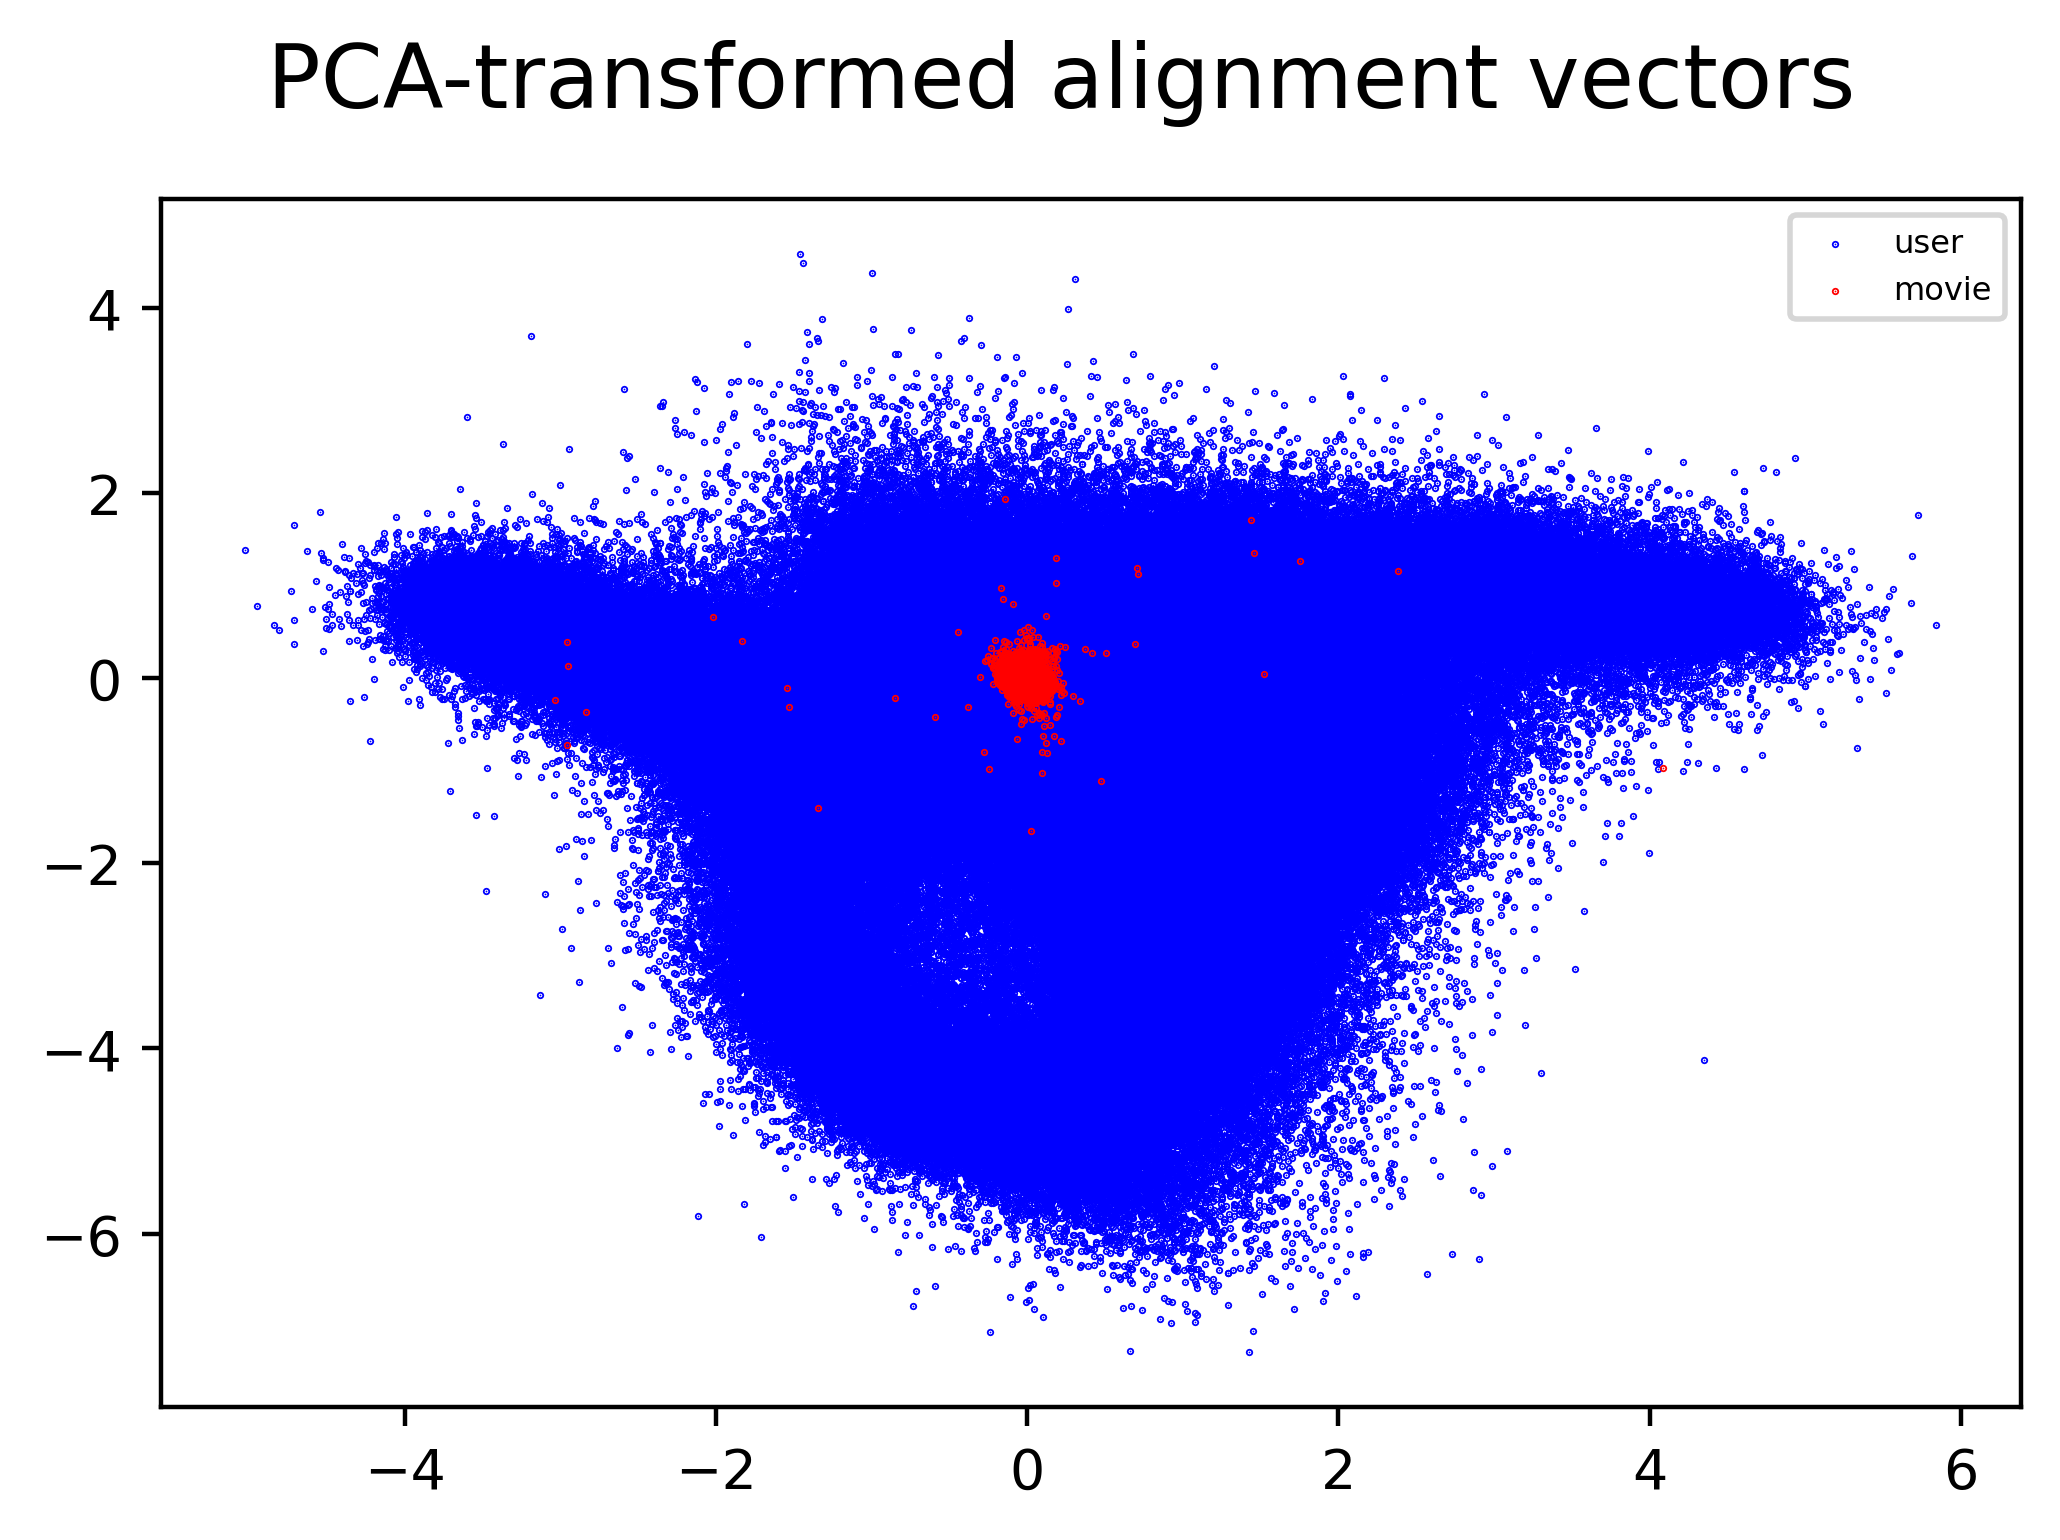

In [11]:
# Plot scatter plots of PCA projections of alignment vectors
plt.scatter(au_pca[:,0], au_pca[:,1], c='blue', s=0.1, label='user')
plt.scatter(bm_pca[:,0], bm_pca[:,1], c='red', s=0.1, label='movie')
plt.suptitle('PCA-transformed alignment vectors', fontsize=16)
plt.legend(loc='best', fontsize='xx-small')
plt.show()

Two key insights can be taken from these data. The first is that the movie alignment vectors seem to remain roughly normally distributed, while the user alignment vectors are indeed clustered. This suggests that the movies have largely defined the dimensions of the alignment space, not the users. The second is that the movie alignments are close to the origin, while the user alignments are more spread out. We can infer that the model has learned that some users' preferences are not particularly strong, while others are extremely opinionated, and that it is usually best to let the user parameters determine the alignment score's magnitude.

### Adding a New User

Now that we have trained the model, we can simulate a cold start scenario (i.e. a new user joins the service). First, we'll make some general recommendations (without user parameters). We begin by loading the movie titles from the appropriate file.

In [12]:
# Peaking at the csv file, we know
# the movie titles are in order
titles = []

with open('Netflix Prize/movie_titles.csv', 'r', encoding='ISO-8859-1') as f:
    csv_f = reader(f, delimiter='\n')
    for row in csv_f:
        titles += [','.join(row[0].split(',')[2:])]
    
f.close()
titles = np.array(titles)

One way to make recommendations in this scenario is to find the movies that have the highest $\delta_m$ values.

In [13]:
print('Your recommendations:')
for title in titles[np.argsort(dm)[:-10:-1]]:
    print(title)

Your recommendations:
Larryboy and the Rumor Weed
Isle of Man TT 2004 Review
Dinosaur Planet
Paula Abdul's Get Up & Dance
The Land Before Time VI: The Secret of Saurus Rock
Sick
Character
The Rise and Fall of ECW
Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo


It seems like Netflix subscribers in 2006 had a variety of tastes, and the top-rated movies and shows seem to represent a variety of genres. We will now suppose that our new user has rated some titles, which we will use to improve our recommendations. In this example, our new customer leaves high ratings for sci-fi and fantasy titles.

__Sample Ratings__
- _Lord of the Rings: The Return of the King: Extended Edition: Bonus Material_ (#12) - 5
- _Lord of the Rings: The Return of the King: Extended Edition_ (#14960) - 5
- _The Lord of the Rings: The Fellowship of the Ring: Extended Edition_ (#7229) - 5
- _Lord of the Rings: The Two Towers: Extended Edition_ (#7056) - 4
- _The Twilight Zone: Vol. 36 (#576)_ - 3
- _Ghost in the Shell: Stand Alone Complex: 2nd Gig_ (#3032) - 4
- _Battlestar Galactica: Season 1_ (#9863) - 5
- _Gattaca (#17761)_ - 5

In [14]:
# Initialize parameters and ratings data
du_new = np.random.normal()
au_new = np.random.normal(size=k)

ratings_by_new_user = np.array([[12, 5], [14960, 5], [7229, 5], [7056, 4],
                       [576, 3], [3032, 4], [9863, 5], [17761, 5]])

l = 0.01

# Learn parameters for model
for i in range(N):
    # Movies rated by user & count thereof
    movies = ratings_by_new_user[:,0]
    num_movies = len(movies)

    # Alignment vectors
    beta = bm[movies]

    # Shared computation between params
    diff = ratings_by_new_user[:,1] - mu - dm[movies]

    # Update delta_new_user
    du_new = (np.sum(diff - beta @ au_new) - 0.5 * l) / num_movies

    # Update alpha_new_user (inverse only exists for # movies > k)
    alpha_sum = (diff - du_new) @ beta
    to_invert = beta.T @ beta + l * np.eye(k)
    if num_movies > k:
        au_new = np.linalg.inv(to_invert) @ alpha_sum
    else:
        au_new = np.linalg.pinv(to_invert, hermitian=True) @ alpha_sum

Now that we've trained the new user parameters, let us examine the new recommendations.

In [15]:
new_ratings = dm + au_new @ bm.T

print('Your recommendations:')
for title in titles[np.argsort(new_ratings)[:-10:-1]]:
    print(title)

Your recommendations:
Isle of Man TT 2004 Review
Paula Abdul's Get Up & Dance
My Bloody Valentine
Dinosaur Planet
Lilo and Stitch
Boycott
Daydream Obsession
Immortal Beloved
The Land Before Time VI: The Secret of Saurus Rock


The recommendations are largely changed, which may be a consequence of overfitting to the initial training set. Therefore, we might want to experiment with the system by assigning different weights to the movie delta compared to the alignment value. We will explore recommendations for a few different parameter weightings.

### Pragmatic Adjustments to the Model

In [16]:
for i in range(5):
    w = 0.5**(i-2)
    new_ratings = w * dm + au_new @ bm.T
    
    print(f'Your recommendations (delta:alignment = {w}:1):')
    for title in titles[np.argsort(new_ratings)[:-6:-1]]:
        print(title)
    
    print()

Your recommendations (delta:alignment = 4.0:1):
Isle of Man TT 2004 Review
Paula Abdul's Get Up & Dance
Dinosaur Planet
Larryboy and the Rumor Weed
My Bloody Valentine

Your recommendations (delta:alignment = 2.0:1):
Isle of Man TT 2004 Review
Paula Abdul's Get Up & Dance
Dinosaur Planet
My Bloody Valentine
Larryboy and the Rumor Weed

Your recommendations (delta:alignment = 1.0:1):
Isle of Man TT 2004 Review
Paula Abdul's Get Up & Dance
My Bloody Valentine
Dinosaur Planet
Lilo and Stitch

Your recommendations (delta:alignment = 0.5:1):
Isle of Man TT 2004 Review
My Bloody Valentine
Paula Abdul's Get Up & Dance
Dinosaur Planet
Lilo and Stitch

Your recommendations (delta:alignment = 0.25:1):
Isle of Man TT 2004 Review
My Bloody Valentine
Paula Abdul's Get Up & Dance
Dinosaur Planet
Daydream Obsession



We see that as the emphasis shifts from generally popular items to items that align with the user's ratings, higher quality recommendations are made. In practice, it appears that more weighting on the alignment score is better, as it includes items likely to appeal to the user's genre preferences. However, this weight should shift slowly as the number of titles the user rates (and therefore the confidence in the alignment vector) increases. Moreover, as the recommendations appear to not be of the same genre as the user appears to prefer, we can conclude that either the model parameters were not sufficiently learned or that most fans of those sci-fi and fantasy movies tend to like these ones. As we have a relatively low MSE on the training set, the latter is more likely. We can check a larger number of ratings based on the alignment scores alone to get a better picture of what types of movies the system recommends.

In [17]:
new_ratings = au_new @ bm.T

print('Your recommendations (alignment only):')
for title in titles[np.argsort(new_ratings)[:-10:-1]]:
    print(title)

Your recommendations (alignment only):
Isle of Man TT 2004 Review
My Bloody Valentine
Paula Abdul's Get Up & Dance
Dinosaur Planet
Daydream Obsession
Lilo and Stitch
Boycott
Class of Nuke 'Em High 2
Sex and the Beauties


Since the movies' popularity is not taken into account, we can see that the system recommends more obscure titles to this user. Moreover, the user's recommendations may not be extremely relevant since they have not rated many titles. To conclude our analysis of this recommender system, let us plot the PCA projections of this user's alignment vector and the alignment vectors of their rated movies and recommendations.

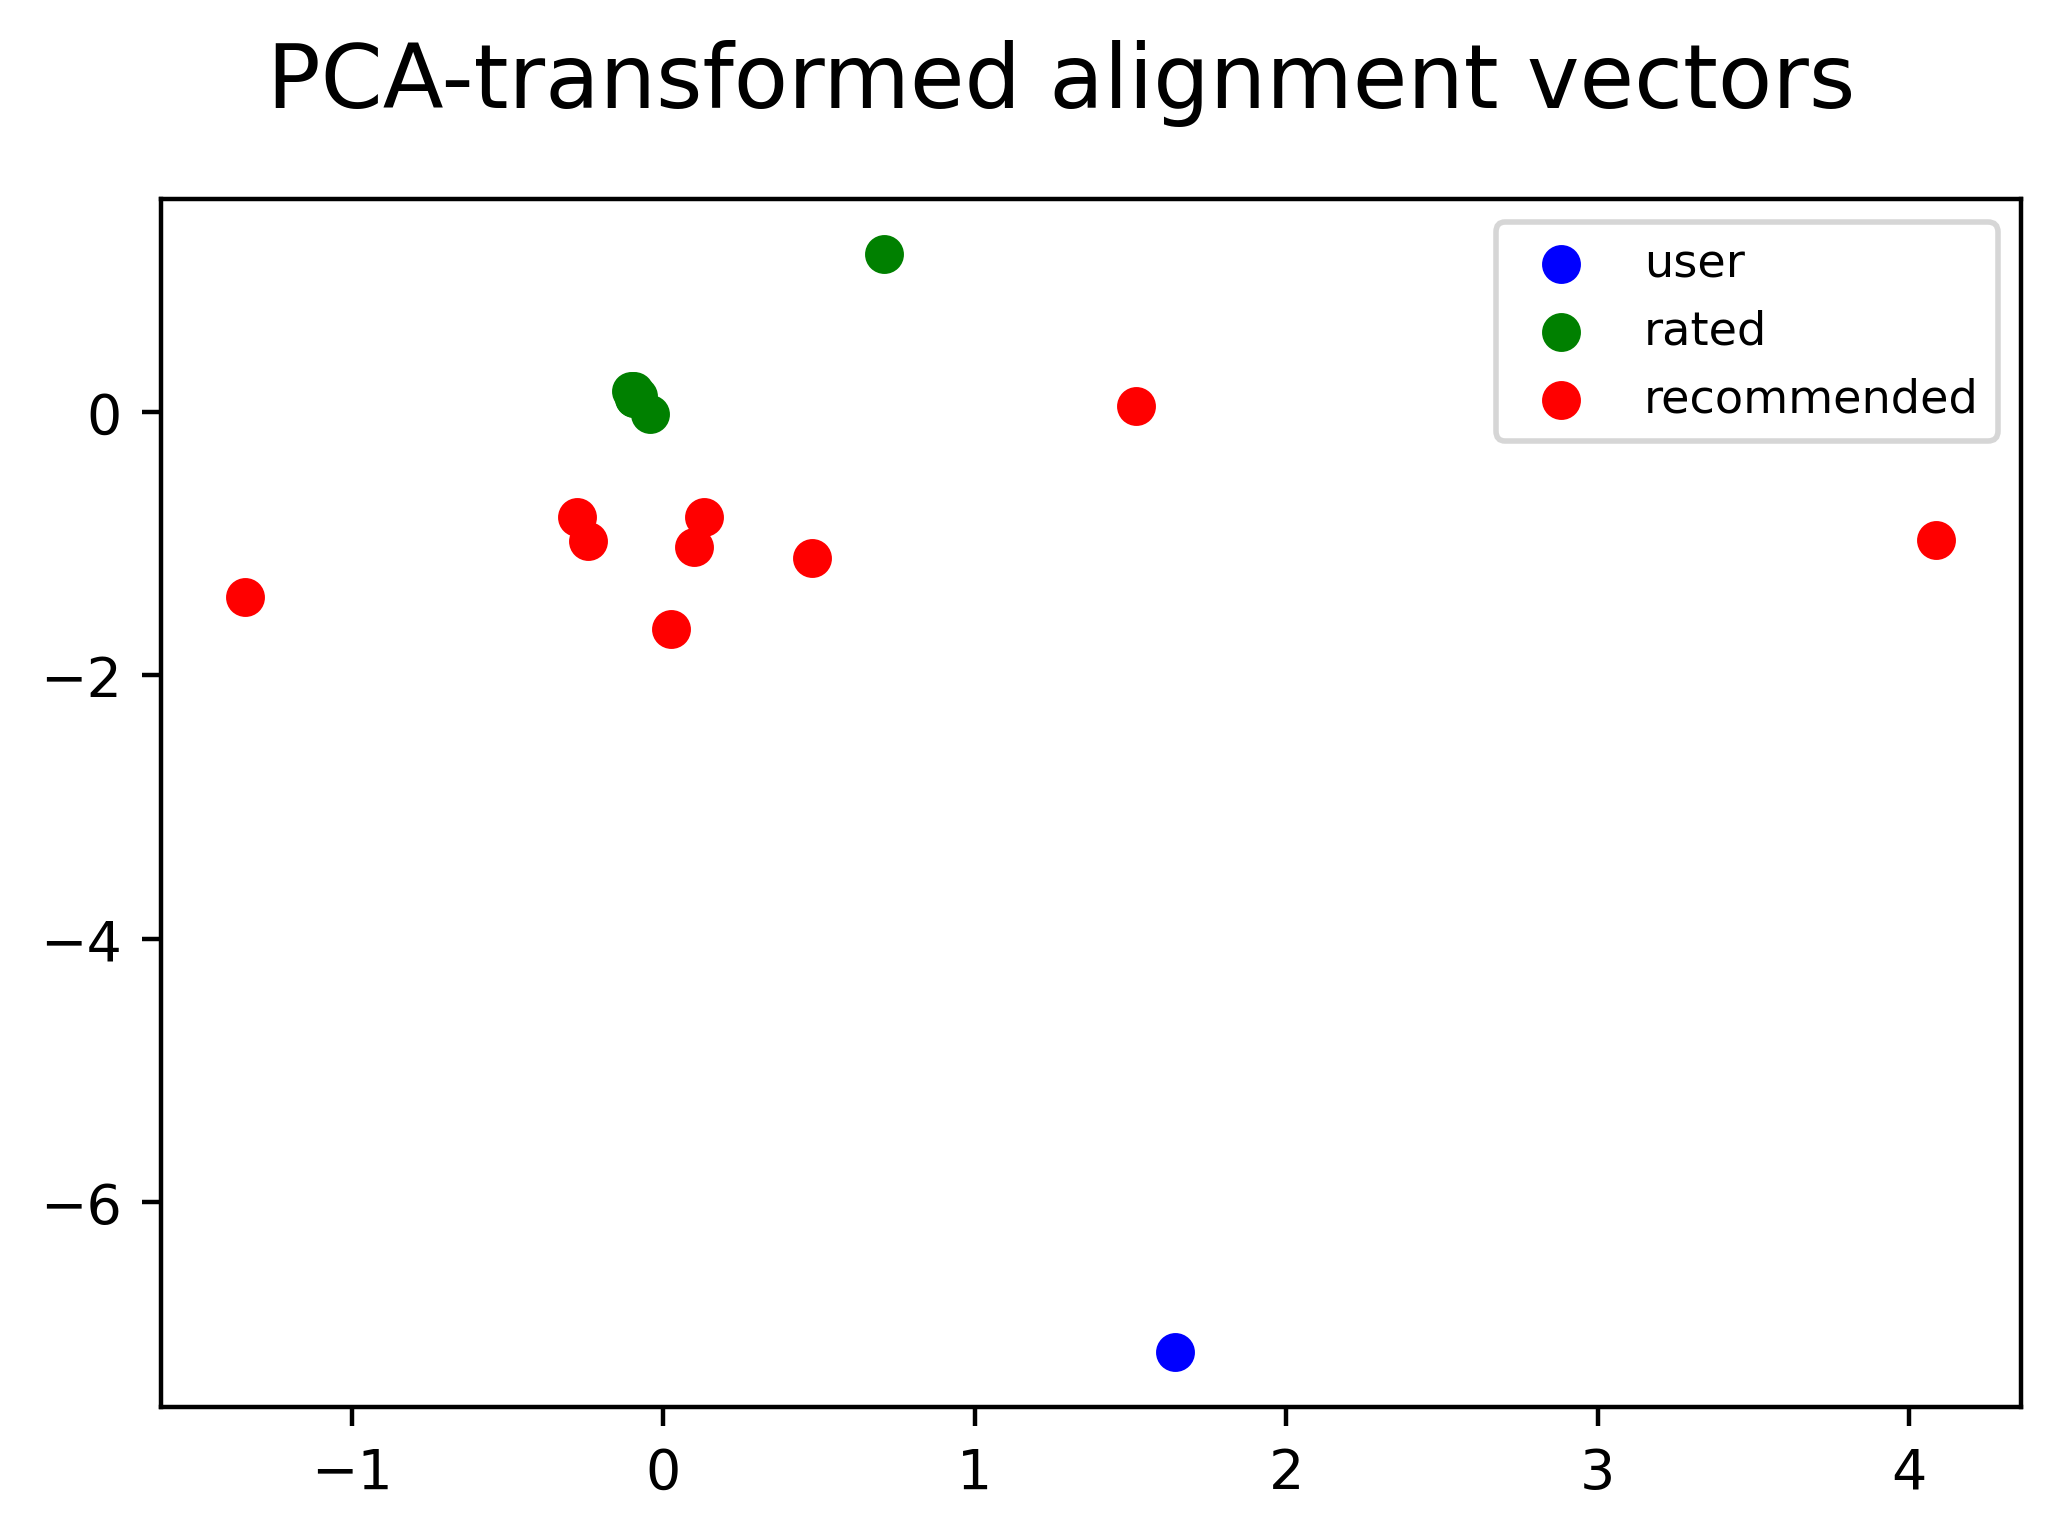

In [19]:
# Transform alignment vectors
au_new_pca = alignment_pca.transform([au_new])
bm_rated_pca = alignment_pca.transform(bm[ratings_by_new_user[:,0]])
bm_pred_pca = alignment_pca.transform(bm[np.argsort(new_ratings)[:-10:-1]])

# Plot scatter plots of PCA projections of alignment vectors
plt.scatter(au_new_pca[:,0], au_new_pca[:,1], c='blue', label='user')
plt.scatter(bm_rated_pca[:,0], bm_rated_pca[:,1], c='green', label='rated')
plt.scatter(bm_pred_pca[:,0], bm_pred_pca[:,1], c='red', label='recommended')

plt.suptitle('PCA-transformed alignment vectors', fontsize=16)
plt.legend(loc='best', fontsize='small')
plt.show()

Although some information is lost in our dimensionality reduction, we see that most recommendations are aligned with the user. Furthermore, these alignments have greater magnitude than those of the rated movies' alignments. This demonstrates the necessity of including the movie popularity term in the recommendations, as most users will tend to rate popular titles, leading to their relocation close to the origin. We can see this in the PCA projections of the popularity-based recommendations below.

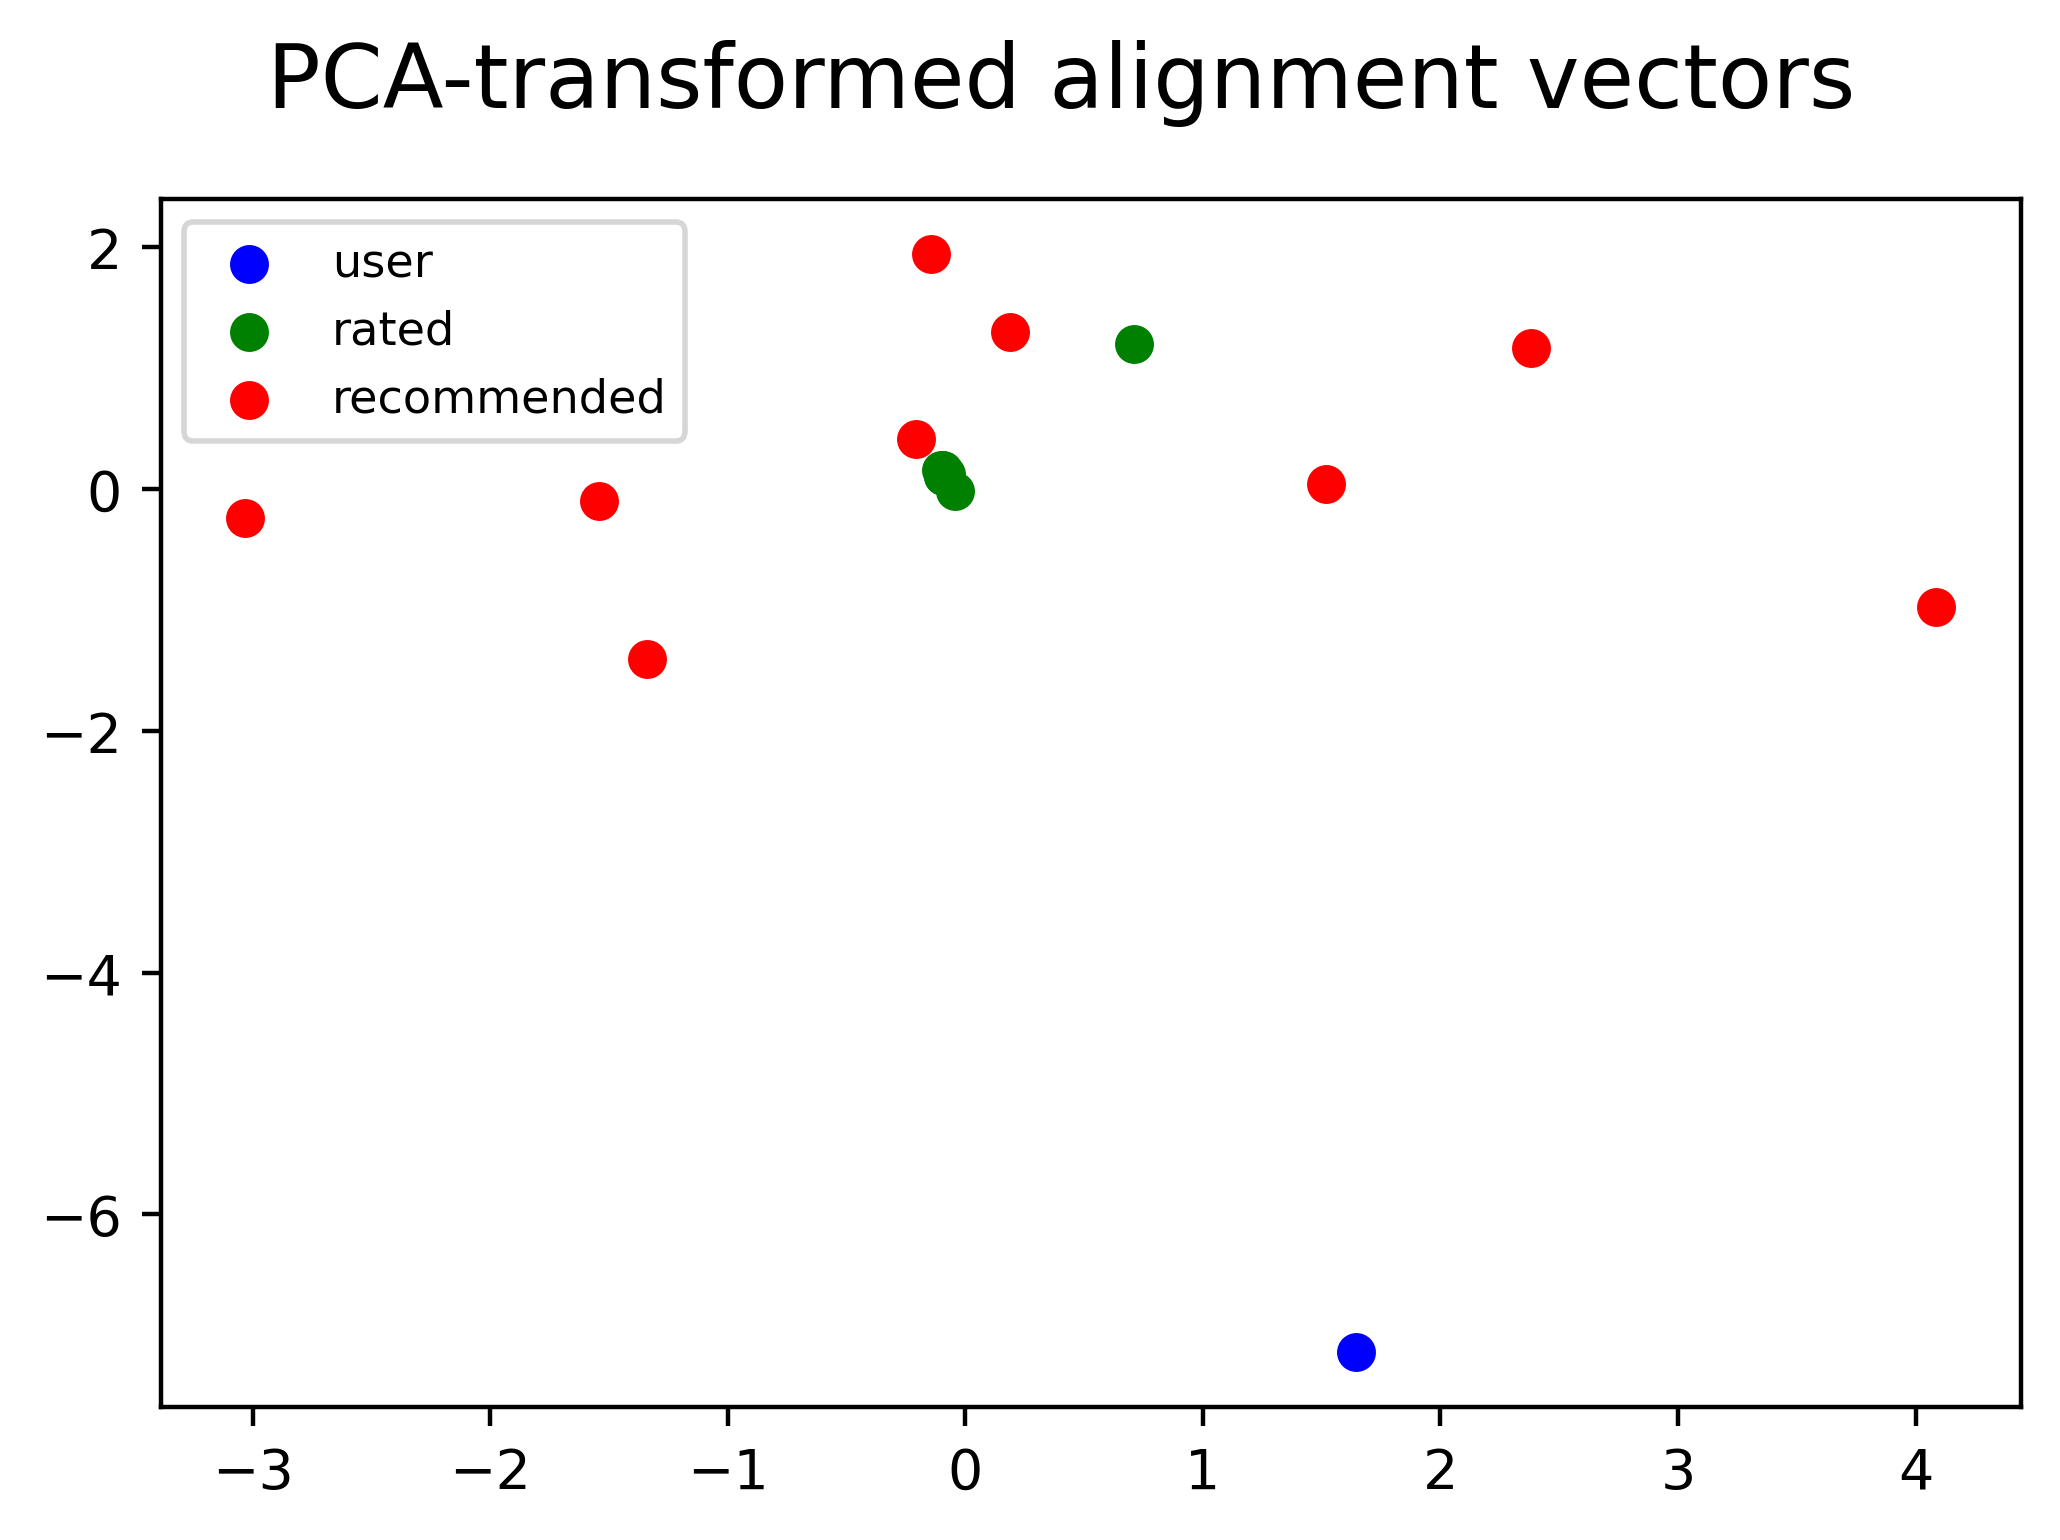

In [21]:
# Transform alignment vectors
bm_pred_pca = alignment_pca.transform(bm[np.argsort(dm)[:-10:-1]])

# Plot scatter plots of PCA projections of alignment vectors
plt.scatter(au_new_pca[:,0], au_new_pca[:,1], c='blue', label='user')
plt.scatter(bm_rated_pca[:,0], bm_rated_pca[:,1], c='green', label='rated')
plt.scatter(bm_pred_pca[:,0], bm_pred_pca[:,1], c='red', label='recommended')

plt.suptitle('PCA-transformed alignment vectors', fontsize=16)
plt.legend(loc='best', fontsize='small')
plt.show()